In [1]:
from fastai import *
from fastai.vision import *
import numpy as np
import os

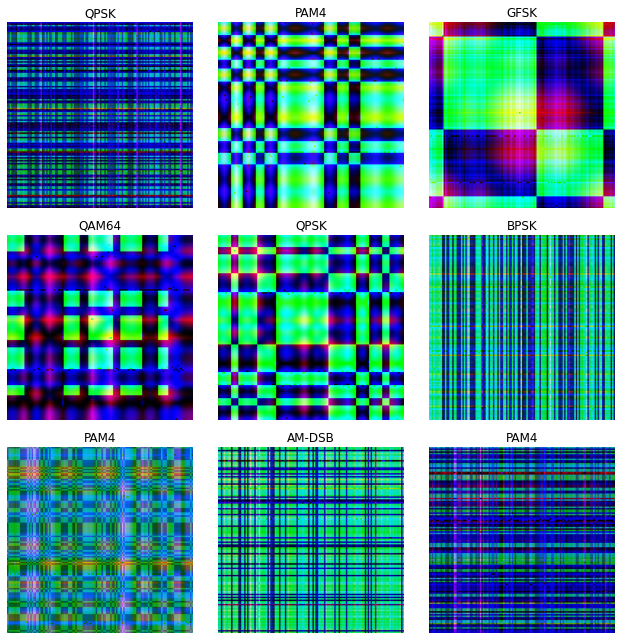

In [2]:
path = os.getcwd() + '/training_zone/2016_rgb'
path = Path(path)
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train= 'train', valid_pct=0.2, num_workers=8, bs=128).normalize()
learn = cnn_learner(data, models.resnet18, metrics=[accuracy, error_rate])
data.show_batch(rows=3, figsize=(9,9))

In [6]:
import torch
print(torch.cuda.get_device_name(0))
torch.cuda.is_available()

GeForce RTX 2080 Ti


True

In [7]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.738746,1.597185,0.408136,0.591864,01:02
1,1.506529,1.442752,0.451364,0.548636,01:01
2,1.428336,1.384908,0.473955,0.526045,01:04
3,1.382680,1.349619,0.487500,0.512500,01:03
4,1.364910,1.331930,0.483068,0.516932,01:00
5,1.340119,1.311062,0.498818,0.501182,01:02
6,1.330947,1.303592,0.501705,0.498295,01:00
7,1.303034,1.301164,0.503068,0.496932,00:59
8,1.302450,1.299685,0.504182,0.495818,00:59
9,1.303420,1.297634,0.504818,0.495182,00:59


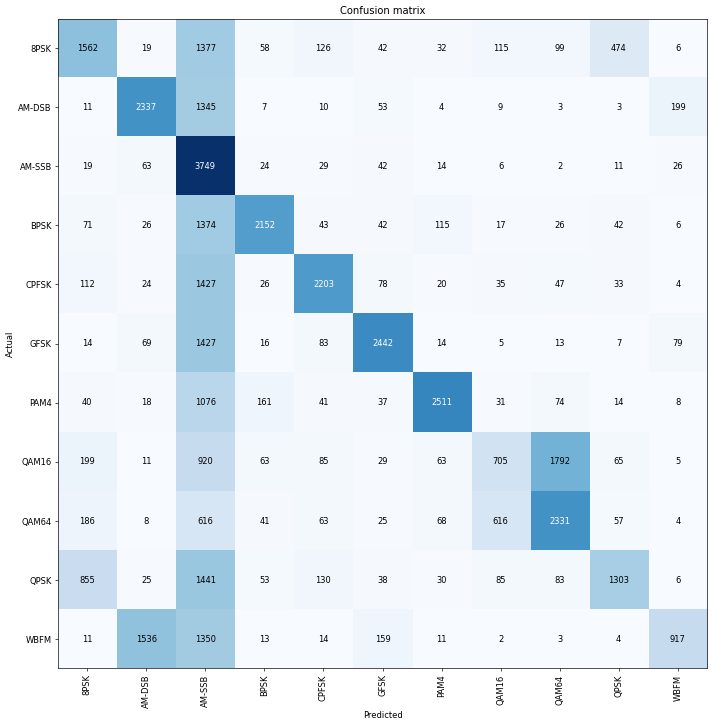

In [8]:
learn.save('stage-1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


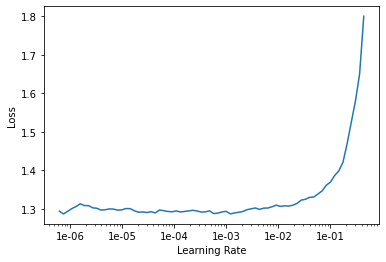

In [9]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


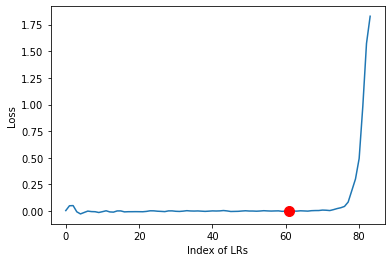

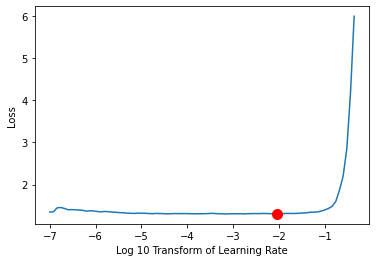

0.009120108393559097

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use
find_appropriate_lr(learn, plot = True)

In [12]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, 0.009120108393559097)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.302071,1.304819,0.505159,0.494841,01:20
1,1.279172,1.351964,0.497523,0.502477,01:22
2,1.242390,1.277871,0.523682,0.476318,01:22
3,1.209683,1.382078,0.531932,0.468068,01:22
4,1.203319,1.202339,0.547341,0.452659,01:20
5,1.166294,1.157932,0.570023,0.429977,01:20
6,1.132401,1.147696,0.570023,0.429977,01:20
7,1.105557,1.133067,0.578136,0.421864,01:19
8,1.050996,1.132649,0.582955,0.417045,01:17
9,1.025577,1.142582,0.582477,0.417523,01:18


In [13]:
learn.save('stage-2')

In [15]:
learn.load('stage-2')
learn.unfreeze()
learn.fit_one_cycle(5, find_appropriate_lr(learn))

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.132801,1.222679,0.550545,0.449455,01:20
1,1.191249,1.171108,0.568932,0.431068,01:23
2,1.136565,1.160396,0.572750,0.427250,01:23
3,1.061232,1.121768,0.586500,0.413500,01:23
4,1.012849,1.137364,0.590455,0.409545,01:21


In [16]:
learn.save("stage-3")
learn.load("stage-3")
#SNR blind model performance almost 60% 
# Now we will test it on each SNR value testset.
# data.add_test()

Learner(data=ImageDataBunch;

Train: LabelList (176000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
8PSK,8PSK,8PSK,8PSK,8PSK
Path: /home/arrowhead/RadioML/training_zone/2016_rgb;

Valid: LabelList (44000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
PAM4,PAM4,QPSK,QAM64,8PSK
Path: /home/arrowhead/RadioML/training_zone/2016_rgb;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1)

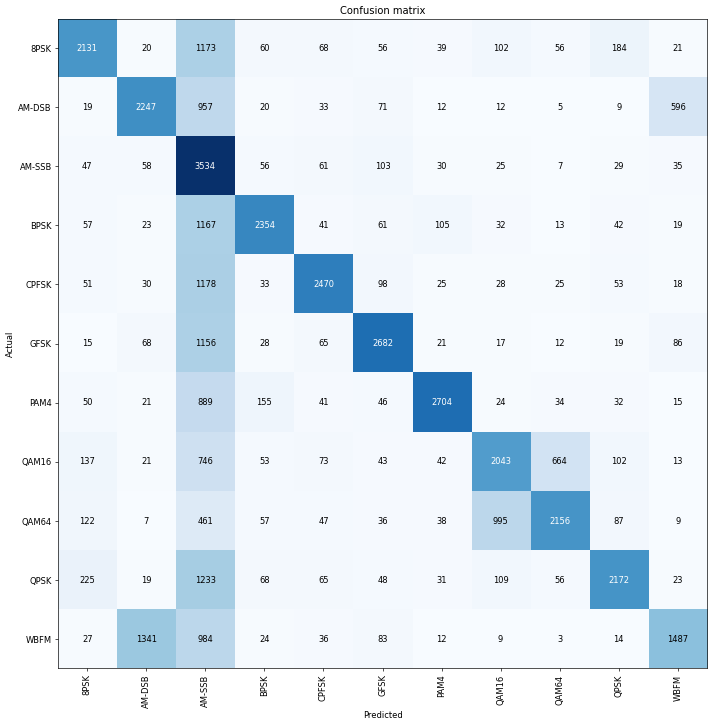

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.314725,0.210360,0.899083,0.100917,00:01


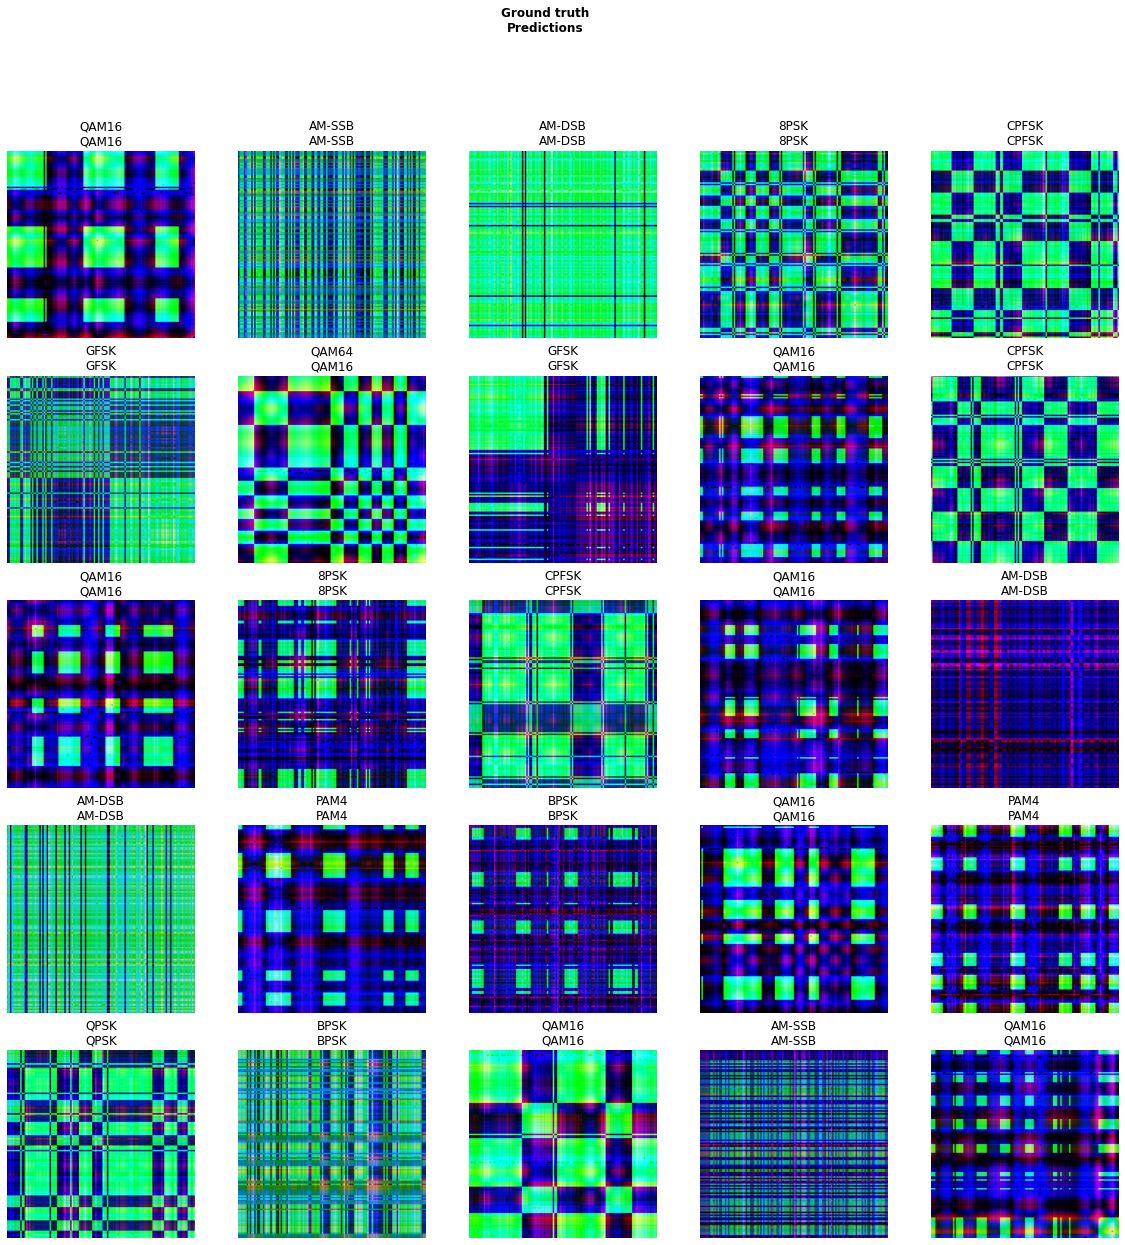

In [40]:
## Testset performance | SNR = 0db
learn.load("stage-3")
test = Path(os.getcwd() + "/training_zone/2016_rgb/test/0")
data_ = ImageDataBunch.from_folder(test, valid_pct = 0.1, num_workers=8, bs=128).normalize()
learn.data = data_
learn.fit_one_cycle(1)
learn.show_results()
# learn.validate(data_.valid_dl)
# print(learn.validate(data_.valid_dl, metrics=accuracy))
# print(f'SNR:{str(0)} Loss: {loss*100} %, Accuracy: {acc*100} %')
# help(learn.validate)
# for i in range(-20, 20, 2):
#     data_ = ImageDataBunch.from_folder(test, valid= str(i), valid_pct = 0.99, num_workers=8, bs=128).normalize()
#     learn.data = data_
#     a,loss, acc = learn.validate(data_.valid_dl)
#     print(f'SNR:{str(i)} Loss: {loss*100} %, Accuracy: {a*100} %')